In [10]:
import sys
import stmpy
import numpy as np
import cancelv3 as cancel
from decimal import *
import matplotlib.pyplot as plt
from sklearn.externals import joblib

import scipy.fftpack as fftp
import os

from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
%pylab inline

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}
matplotlib.rc('font', **font)

from scipy import signal

Populating the interactive namespace from numpy and matplotlib


In [11]:
# A function that returns array with the n-th degree polynomial background removed. 
def fit_cancel(array, n=1):
    t=linspace(0,len(array),len(array))
    fit = polyfit(t,array,n)
    corrective = fit[n]*ones(shape(t))
    for j in arange(n):
        corrective += fit[j]*(t**(n-j))
    return array - corrective

# Same implementation as in cancelv3.py. but with any given transfer function/frequencies.
# Useful when storing a transfer function as a 2D array of complex numbers/frequencies.
def create_drive(zdata, dt2, tf, freqs):
    fbottom2 = np.fft.fft(zdata)
    freq2 = np.fft.fftfreq(len(zdata),dt2)
    freq2[freq2 > freqs[np.argmax(freqs)]] = freqs[np.argmax(freqs)]
    freq2[freq2 < freqs[np.argmin(freqs)]] = freqs[np.argmin(freqs)]
    driver = np.fft.ifft(tf(freq2)*fbottom2)
    return driver

# low pass filter with a cutoff frequency equivalent to n samples.
def lpfilter(array,n):
    return repeat(mean(array.reshape(-1,n),axis=1),n)

# Divide by mean
def normalize(array):
    return array/mean(array)

# Subtract mean and divide by range.
def normalize2(array):
    return (array-mean(array))/(max(array) - min(array))

C:\Users\jgoet\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


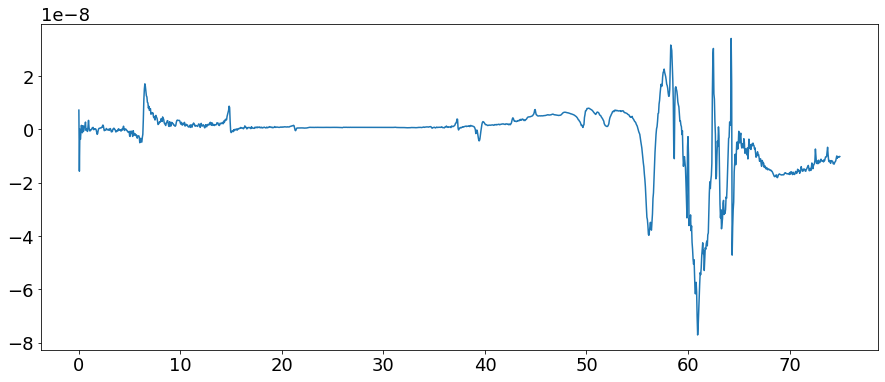

In [12]:
figsize(15,6)
[transf, freqs] = joblib.load('Albert_Data/2019-02-26/trx2_v2') # load a previously calibrated transfer function
plot(freqs[:1500],transf(freqs[:1500]))

(2012200,)


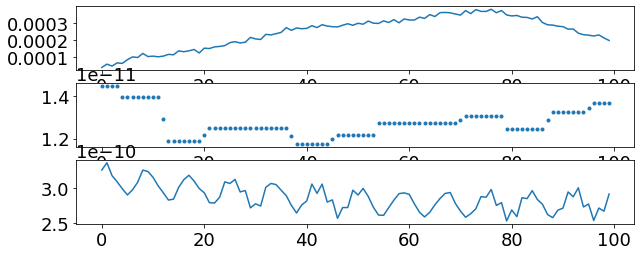

In [13]:
# load data - noisy conditions with lock-in running

folder_name = 'Albert_Data/2019-02-25/'
file_name = 'noisy_cur_10khz-'

i = 1
temp_data = np.loadtxt(folder_name+file_name+str(i).zfill(3)+".dat", skiprows=6)
# os.remove(folder_name+date_string+file_name+"%(number)03d"%{"number": i}+".dat")
while True:
    i += 1
    try:
        temp_data = np.concatenate((temp_data, np.loadtxt(folder_name+file_name+str(i).zfill(3)+".dat", skiprows=6)))
        # os.remove(folder_name+date_string+file_name+"%(number)03d"%{"number": i}+".dat")
    except:
        break
        
geo=temp_data[:,2]
liy=temp_data[:,-1]
cur=temp_data[:,0]
fig,ax = subplots(3,1,figsize = [10,4])
ax[0].plot(geo[:100])
ax[1].plot(liy[:100],'.')
ax[2].plot(cur[:100])
print(shape(cur))

-16313539785.538061


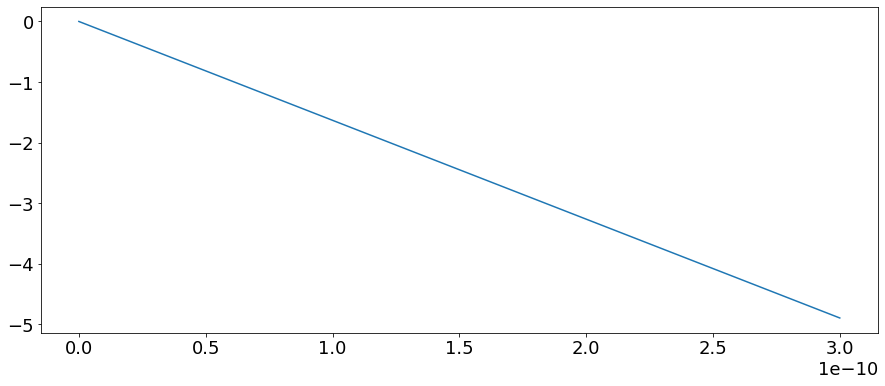

In [14]:
# log fitting on Z spectroscopiy data to get kappa (fit[0])
foldername='Albert_Data/2019-02-25/'

i=1
z_spec=loadtxt(foldername+'Z-Spectroscopy-noisy001.dat',skiprows=62)
fit = polyfit(z_spec[:,0],log(abs(z_spec[:,1])),1)
plot(z_spec[:,0],fit[0]*z_spec[:,0])
# semilogy(z_spec[:,0],1e10*absolute(z_spec[:,1]))
# plot(z_spec[:,0],fit[0]*z_spec[:,0])
print(fit[0])

-1.40571e-09


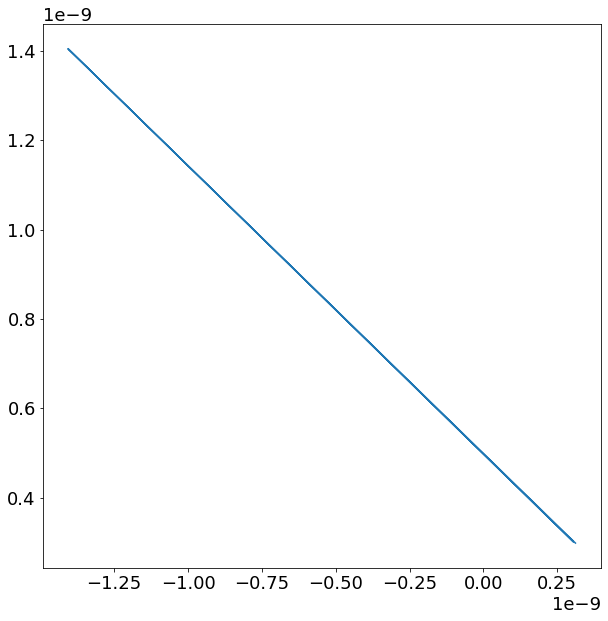

In [15]:
figsize(10,10)
x = z_spec[0]
y = z_spec[1]
p = np.poly1d(np.polyfit(x[1:], log(abs(y[1:])),1))
print(x[-1])
t = np.linspace(0, x[-1], 2000)
plot((x[1:]), (abs(y[1:])))#, '-', x, p(x), '-')
# ylim(-23,-20)
# plt.show()

In [16]:
# plotting parameters/variables

start=5000
end=2000000
t=linspace(0,(start-end)/-10,end-start)

In [17]:
# find the Z noise and current noise based on the transfer function and kappa
z_noise=create_drive(geo,1/10000,transf,freqs)
cur_noise=exp(-(z_noise-mean(z_noise))*fit[0])

# Exact Propagation Approach

No handles with labels found to put in legend.


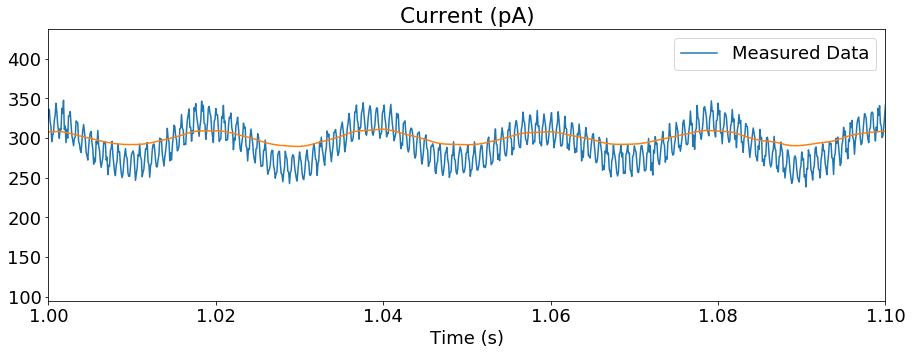

In [36]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}
matplotlib.rc('font', **font)

figsize(15,5)
title('Current (pA)')
xlabel('Time (s)')
legend()

start=0
end=2000000

t=linspace(0,(start-end)/-10000,end-start)

delay=10 # a delay may be necessary to compensate for any time-effects between geophone/Z and current data
plot(t,cur[start:end]*1e12,label='Measured Data')
# plot(t,cur[start:end]/cur_noise[start+delay:end+delay]*1e12,label='Processed Data')
plot(t,200+1e2*cur_noise[start+delay:end+delay])
# plot(t,geo[:end])
xlim(1,1.1)
# ylim(225,375)
legend(loc=1)


In [ ]:
plot(cur)
plot(cur_noise)

In [9]:
# print(shape(cur))
# # freq1 = fft.fft(geo[1550000:1650000])
# freq2 = fft.fft(geo[1150000:1750000])/175
# freqs = fft.fftfreq(len(freq2),1/10000)
# print(shape(freq1))
# loglog(freqs[0:int(len(freqs)/2)],absolute(freq2[0:int(len(freqs)/2)]),label = 'Vibration Peak')
# # plot(freqs[1:50000],absolute(freq1[1:50000]),label = 'Vibration Floor')
# xlim(0,400)
# # ylim(0,0.005)
# legend()

### An attempt to replicate the Nanonis lock-in amplifier (See bottom of notebook)

# Z-LIY Propagation

2012200


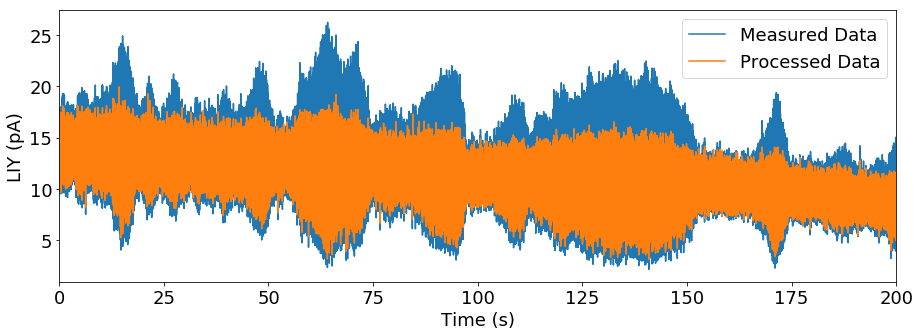

In [10]:
start=0
end=2000000

t=linspace(0,(start-end)/-10000,end-start)

figsize(15,5)
plot(t,liy[start:end]*1e12,label='Measured Data')

# not sure why there exists a delay between liy and cur_noise
delay=32
del2 = 0
plot(t[:-delay],liy[start:end-delay]/(repeat(mean(cur_noise[start+delay+del2:end+del2].reshape(-1,8),axis=1),8))*1e12,label='Processed Data')
xlabel('Time (s)')
xlim(0,(end-start)/10000)
ylabel('LIY (pA)')
legend()
print(len(cur_noise))

# G-LIY approach

1012200 2012200


Text(0.5, 0, 'Time (s)')

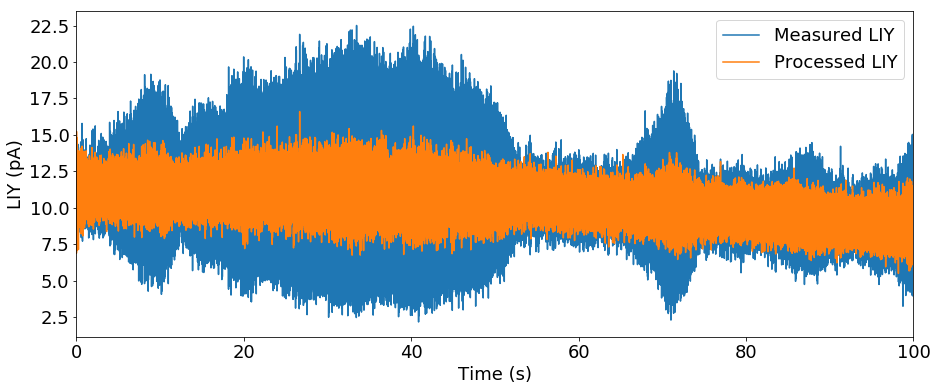

In [11]:
figsize(15,6)
init=1000000
init1=0
init2=1000000
tester=1000000

test_trx = cancel.Cancel(geo[init1:init2]-mean(geo[init1:init2]), fit_cancel(log(cur[init1:init2])), 1/10000, p=[200000,50000,5])

t=linspace(0,1012200/10000,1012200)

test_trx = cancel.Cancel(geo[:init]-mean(geo[:init]), fit_cancel(liy[:init]), 1/10000, p=[200000,50000,5])
plot(t,liy[tester:]*1e12, label='Measured LIY')
print(len(t),len(liy))
# plot(liy[tester:]-test_trx.create_drive(geo[tester:]-mean(geo[tester:])),'r',label='Processed',alpha=0.5)
plot(t,liy[tester:]*1e12-stmpy.tools.butter_lowpass_filter(test_trx.create_drive(geo[tester:]-mean(geo[tester:])), ncutoff=300/10000)*1e12,label='Processed LIY')
legend()
xlim(0,100)
ylabel('LIY (pA)')
xlabel('Time (s)')

C:\Users\jgoet\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1819: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


Text(0.5, 0.96, 'LIY ASD (pA $\\cdot$ Hz$^{-1/2}$)')

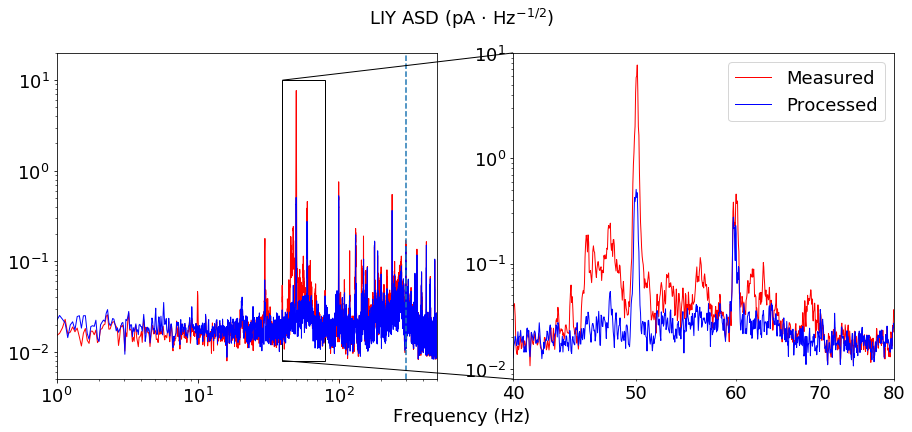

In [12]:
from scipy import signal
    
tester=1000000
trace.i1 = liy[tester:]-stmpy.tools.butter_lowpass_filter(test_trx.create_drive(geo[tester:]-mean(geo[tester:])), ncutoff=300/10000)
trace.i2 = liy[tester:]

trace.w1, trace.psd1 = signal.welch(trace.i1, 10000, nperseg=200000)
trace.w2, trace.psd2 = signal.welch(trace.i2, 10000, nperseg=200000)

import matplotlib.ticker as mticker

fig, ax = subplots(1,2,figsize=(15,6))
for a in ax:
    a.loglog(trace.w2, sqrt(trace.psd2)*1e12, 'r-', lw=1, label='Measured')
    a.loglog(trace.w1, sqrt(trace.psd1)*1.45e12, 'b-', lw=1, label='Processed')

ax[0].axvline(x=300,linestyle='dashed')
ax[1].xaxis.set_minor_formatter(mticker.ScalarFormatter())

ax[0].set_xlim(1,500)
ax[0].set_ylim(5e-3,20)
mark_inset(ax[0],ax[1],3,2)
ax[1].set_xlim(40,80)
ax[1].set_ylim(8e-3,10)

legend()

fig.text(0.5, 0.04, 'Frequency (Hz)', ha='center', va='center')
fig.text(0.5, .96, 'LIY ASD (pA $\cdot$ Hz$^{-1/2}$)', ha='center', va='center')


# G-log(LIY) approach

Text(0, 0.5, 'LIY (pA)')

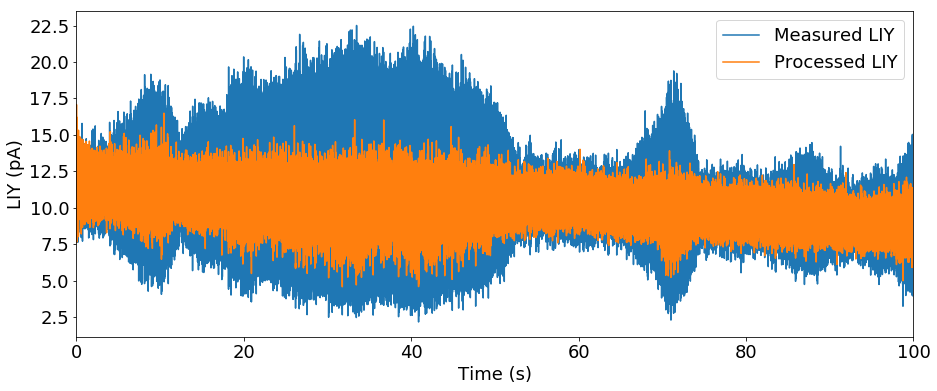

In [13]:
figsize(15,6)
t=linspace(0,1012200/10000,1012200)
init=1000000
tester=1000000
test_trx = cancel.Cancel(geo[:init]-mean(geo[:init]), fit_cancel(log(liy[:init])), 1/10000, p=[200000,50000,5])
plot(t,liy[tester:]*1e12,label='Measured LIY')
# plot(exp(log(liy[tester:])-test_trx.create_drive(geo[tester:]-mean(geo[tester:]))),'r',label='Processed',alpha=0.5)
plot(t,exp(log(liy[tester:])-stmpy.tools.butter_lowpass_filter(test_trx.create_drive(geo[tester:]-mean(geo[tester:]))))*1e12,label='Processed LIY')
xlim(0,100)
legend()
xlabel('Time (s)')
ylabel('LIY (pA)')

### An attempt to replicate the Nanonis lock-in amplifier

In [14]:
# load data
file_name = "lock-in-test"
folder_name = "Albert_Data/Sim Data/"

i = 1
temp_data = np.loadtxt(folder_name+file_name+"%(number)03d"%{"number": i}+".dat", skiprows=7)
# os.remove(folder_name+date_string+file_name+"%(number)03d"%{"number": i}+".dat")
while True:
    i += 1
    try:
        temp_data = np.concatenate((temp_data, np.loadtxt(folder_name+file_name+"%(number)03d"%{"number": i}+".dat", skiprows=7)))
        # os.remove(folder_name+date_string+file_name+"%(number)03d"%{"number": i}+".dat")
    except:
        break
        
cur = temp_data[:,0]
v = temp_data[:,1]
lix = temp_data[:,2]
liy = temp_data[:,3]



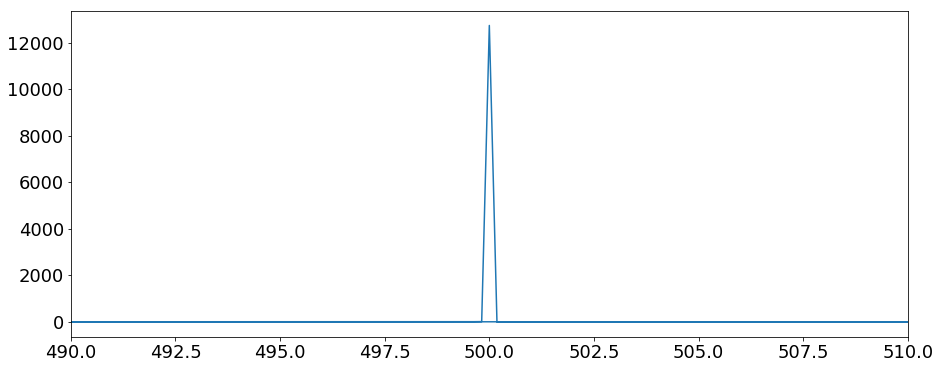

In [15]:

a=19
v_ac = v-mean(v) # removes V_DC and only considers V_AC
plot(fft.fftfreq(len(v_ac),1/10000),fft.fft(v_ac))
xlim(490,510)
coefficient = 1250/10000 # This term is supposed to be 1/T, where T is lock-in period. However, this does not match the Nanonis output.
lix_calc = coefficient*sum((cur[:-a]*v_ac[a:])[:54760].reshape(-1, 20), axis=1) # this calculation replicates the lock-in integral
# plot(lix_calc)
# plot(v_ac)

# plot(v_ac[::20])
# plot(lix_calc)
# plot(lix[::20])

(0, 50)

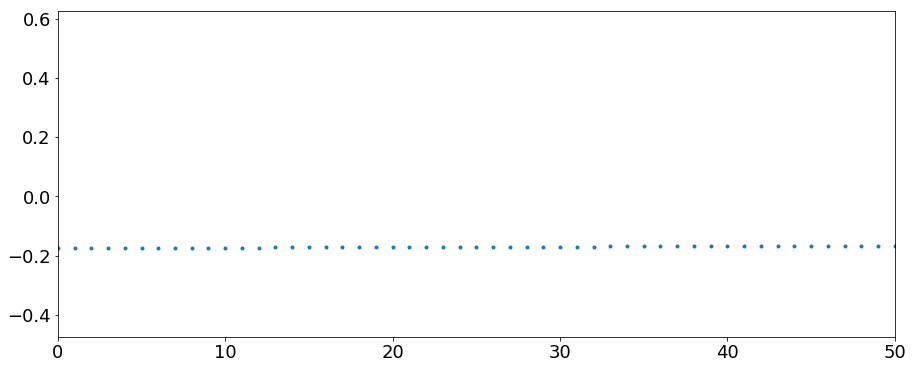

In [16]:
# Although the values are different, the shape of the curve is very promising.
plot(normalize2(lix),'.')
# plot(normalize2(lix_calc))
xlim(0,50)

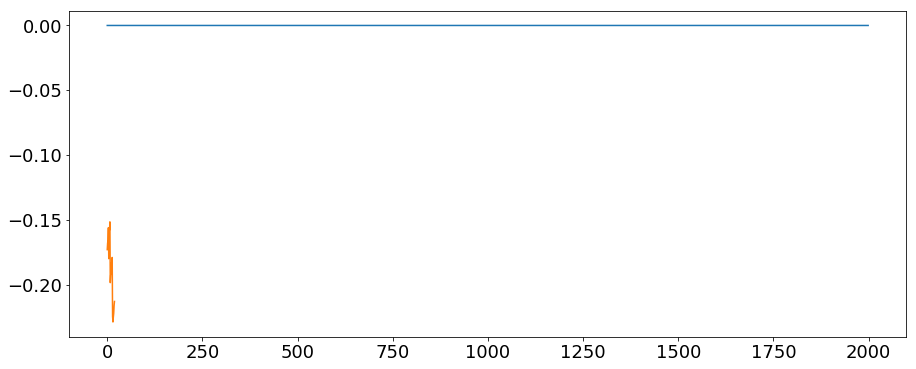

In [17]:
norm_lix = (lix)
norm_lix_calc = normalize2(lix_calc)

plot(norm_lix[:2000])
plot(norm_lix_calc[:20])